In [1]:
import xarray as xr
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
from src import config_cesm
from src.models.diagnostics import roll_metric
from src.utils import util_cesm
REFERENCE_GRID = util_cesm.generate_sps_grid()

def add_hatching(ax, significance_mask, x_edges, y_edges, hatch='///', edgecolor='k'):
    Ny, Nx = significance_mask.shape

    for i in range(Ny):
        for j in range(Nx):
            if significance_mask[i, j]:
                rect = mpatches.Rectangle(
                    (x_edges[j], y_edges[i]),
                    x_edges[j+1] - x_edges[j],
                    y_edges[i+1] - y_edges[i],
                    hatch=hatch,
                    fill=False,
                    edgecolor=edgecolor,
                    linewidth=0
                )
                ax.add_patch(rect)

def plot_markers(ax, exceeds_persistence, x_centers, y_centers):
    for i in range(6):
        for j in range(12):
            if not exceeds_persistence[i,j]:
                ax.plot(x_centers[j], y_centers[i], '.k', markersize=4) 

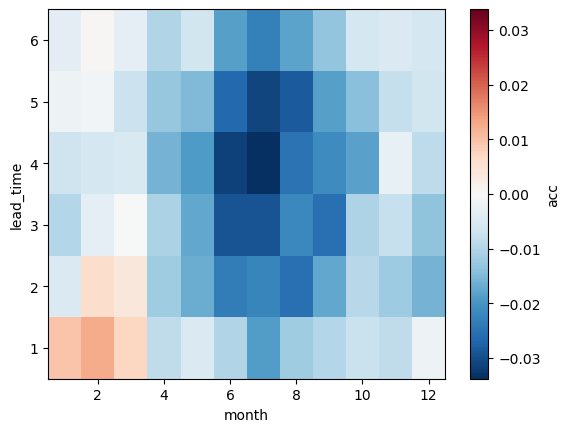

In [8]:
acc_agg = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/acc_agg.nc")["acc"]
acc_agg_old = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/acc_agg_old.nc")["acc"]

(acc_agg - acc_agg_old).sel(nn_member_id=np.arange(20)).mean("nn_member_id").plot()

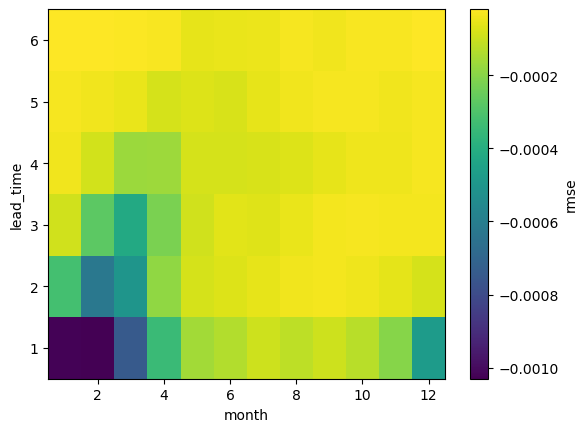

In [15]:
rmse_agg = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/rmse_agg.nc")["rmse"]
rmse_agg_old = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/rmse_agg_old.nc")["rmse"]

(rmse_agg - rmse_agg_old).sel(nn_member_id=np.arange(20)).mean("nn_member_id").plot()

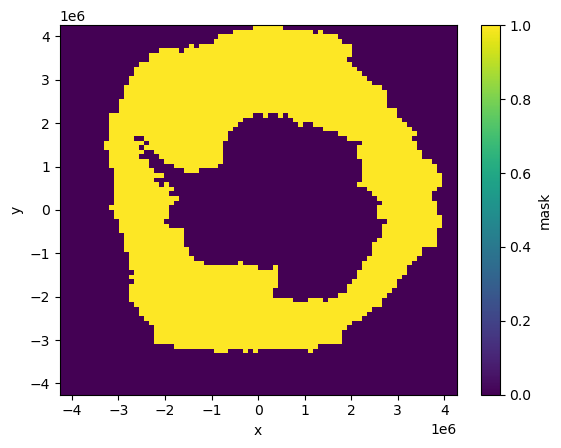

In [10]:
xr.open_dataset("/oak/stanford/groups/earlew/yuchen/obs_data/ice_occurrence_mask.nc")["mask"].plot()

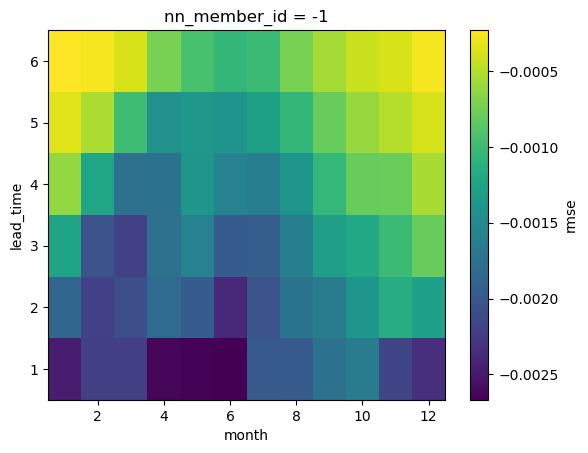

In [29]:
rmse_agg = xr.open_dataset("/scratch/users/yucli/sicpred_model_predictions/obs_input2_ensemble/diagnostics/rmse_agg.nc")["rmse"]

(rmse_agg.sel(nn_member_id=-1) - rmse_agg.sel(nn_member_id=np.arange(20)).mean("nn_member_id")).plot()

In [19]:
acc_agg.mean("nn_member_id").expand_dims({"nn_member_id": [-1]})

<xarray.DataArray 'acc' (nn_member_id: 1, lead_time: 6, month: 12)> Size: 576B
array([[[ 0.64446219,  0.66405773,  0.62504732,  0.60677952,
          0.6413324 ,  0.6438043 ,  0.52854784,  0.63894696,
          0.61914281,  0.69283453,  0.60976679,  0.57237306],
        [ 0.35637477,  0.47171887,  0.60183396,  0.45501514,
          0.41998579,  0.4499542 ,  0.37465214,  0.34199346,
          0.36345214,  0.4217358 ,  0.3986526 ,  0.220932  ],
        [ 0.18260878,  0.2733035 ,  0.47302389,  0.42909409,
          0.34709116,  0.3560804 ,  0.28893709,  0.24169132,
          0.08313382,  0.25092455,  0.22429943,  0.10657914],
        [ 0.08762801,  0.16926541,  0.31698486,  0.3430037 ,
          0.25859176,  0.28855623,  0.23431195,  0.18430739,
          0.03234663, -0.01181264,  0.14353591,  0.01181177],
        [ 0.02458296,  0.08357689,  0.17178007,  0.21799653,
          0.19945415,  0.19248616,  0.17678918,  0.15095459,
          0.03875987, -0.04425487,  0.02283012,  0.02103526],
        [ 0.00738899,  0.01951733,  0.08351075,  0.09241361,
          0.15389175,  0.14208949,  0.12252004,  0.10776165,
          0.04399735, -0.03339052, -0.00430061,  0.00925342]]])
Coordinates:
  * nn_member_id  (nn_member_id) int64 8B -1
  * lead_time     (lead_time) int64 48B 1 2 3 4 5 6
  * month         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12